<a href="https://colab.research.google.com/github/anujsaxena/Python/blob/main/Deep_LSTM_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM**

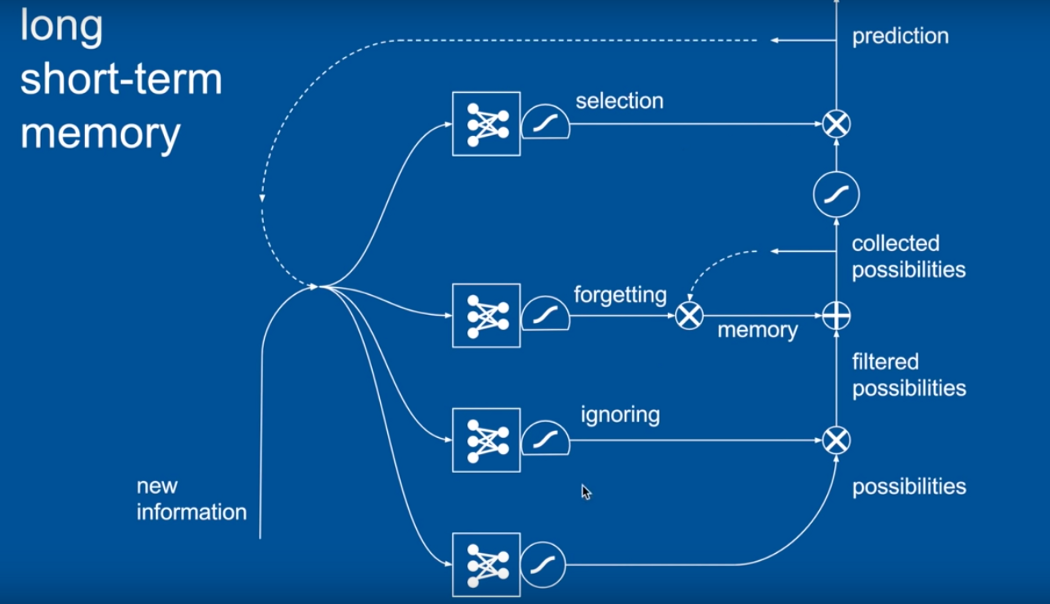

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

df_train = pd.read_csv('train.tsv', sep='\t')
print('train set: {0}'.format(df_train.shape))
df_train.head(10)

train set: (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


ASCII characters are ultimately interpreted by the computer as hexadecimal. In consequence, to a computer, ‘A’ is not the same as ‘a’. Therefore, we’ll want to change all characters to lowercase. Since we’re going to be splitting the sentences up into individual words based off of white spaces, a word with a period right after it is not equivalent to one without a period following it (happy. != happy). In addition, contractions are going to be interpreted differently than the original which will have repercussions for the model (I’m != I am). Thus, we replace all occurrences using the proceeding function.

In [2]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [3]:
X_train = df_train['Phrase'].apply(lambda p: clean_text(p))

max phrase len: 53


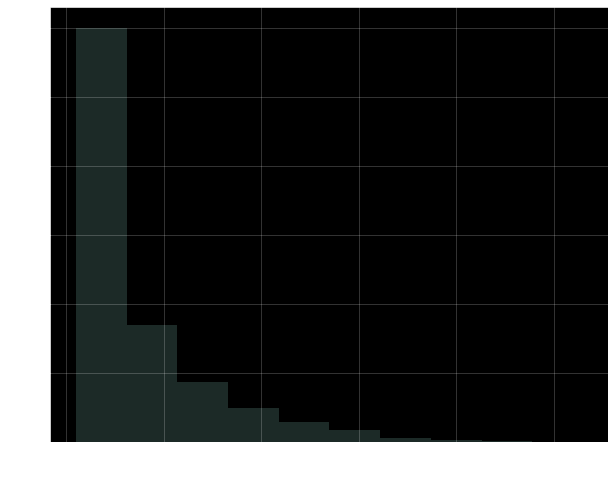

In [4]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [5]:
y_train = df_train['Sentiment']

Computers don’t understand words, let alone sentences, therefore, we use the tokenizer to parse the phrases. In specifying num_words, only the most common num_words-1 words will be kept. We use a filter to remove special characters. By default, all punctuation is removed, turning the text into a space separated sequence of words. The tokens are then vectorized. By vectorized we mean that they are mapped to integers. 0 is a reserved index that won't be assigned to any word.

pad_sequence is used to ensure that all the phrase are the same length. Sequences that are shorter than maxlen are padded with value (0 by default) at the end.

Whenever we’re working with categorical data, we don’t want to leave it as integers because the model will interpreted the samples with a higher number as having more significance. to_categorical is quick and dirty way of encoding the data.

In [6]:
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
y_train = to_categorical(y_train)

In [7]:
#define hyper parameters

batch_size = 512
epochs = 8

#build the model

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 256, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

Dropout is used to avoid overfitting

In [8]:
#validate the data
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 8,
    batch_size = 512
)

Epoch 1/8
275/275 [==============================] - 791s 3s/step - loss: 1.0563 - accuracy: 0.5797 - val_loss: 1.0157 - val_accuracy: 0.5902
Epoch 2/8
275/275 [==============================] - 793s 3s/step - loss: 0.8475 - accuracy: 0.6603 - val_loss: 0.9964 - val_accuracy: 0.5999
Epoch 3/8
275/275 [==============================] - 787s 3s/step - loss: 0.7946 - accuracy: 0.6790 - val_loss: 1.0067 - val_accuracy: 0.5964
Epoch 4/8
275/275 [==============================] - 814s 3s/step - loss: 0.7622 - accuracy: 0.6904 - val_loss: 1.0140 - val_accuracy: 0.6064
Epoch 5/8
275/275 [==============================] - 783s 3s/step - loss: 0.7354 - accuracy: 0.6995 - val_loss: 1.0322 - val_accuracy: 0.6037
Epoch 6/8
275/275 [==============================] - 808s 3s/step - loss: 0.7120 - accuracy: 0.7077 - val_loss: 1.0769 - val_accuracy: 0.5955
Epoch 7/8
275/275 [==============================] - 804s 3s/step - loss: 0.6949 - accuracy: 0.7145 - val_loss: 1.0752 - val_accuracy: 0.6028
Epoch 

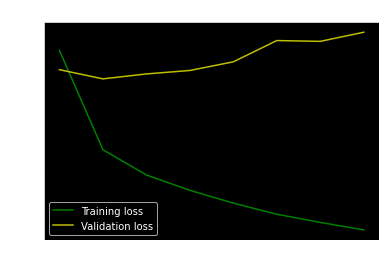

In [9]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

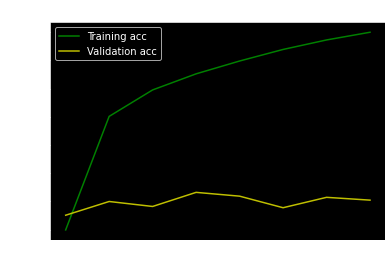

In [11]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()